# HW2 Resubmission (Questions 1, 3.4, and 4.2)


# Question 1

<img src = 'IMG_0016.jpeg'>

# Question 2

<img src = '2.jpeg'>

In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import beta
%matplotlib inline

# Question 3

In [2]:
def plotbetapdfs(ab, sp_idx, tally):
    # ab is a 3-by-2 matrix containing the a,b parameters for the
    # priors/posteriors
    # Before the first flip: ab = [[1, 1], [0.5, 0.5], [50, 50]]
    #
    # sp_idx is a 3-tuple that specfies in which subplot to plot the current
    # distributions specified by the (a,b) pairs in ab.
    # 
    # tally is a 2-tuple (# heads, # tails) containing a running count of the
    # observed number of heads and tails.
    # Before the first flip: tally=(0,0)

    num_rows = np.shape(ab)[0]
    mark = ['b-','r:','g--'];

    if 'axes' not in globals():
        global fig
        global axes
        fig, axes = plt.subplots(sp_idx[0], sp_idx[1])
        fig.set_figheight(10)
        fig.set_figwidth(10)
    elif np.shape(axes)[0] != sp_idx[:2][0] or np.shape(axes)[1] != sp_idx[:2][1]:
        print(sp_idx[:2])
        print(list(np.shape(axes)))
        fig, axes = plt.subplots(sp_idx[0], sp_idx[1])
        fig.set_figheight(10)
        fig.set_figwidth(10)

    for row in range(num_rows):
        a = ab[row][0]
        b = ab[row][1]
        
        x = np.linspace(0.001, 0.999, num=999)
        y = beta.pdf(x, a, b)
        norm_y = y / max(y)
        
        marker = mark[row]
        ax = axes[sp_idx[2]//sp_idx[1], sp_idx[2]%sp_idx[1]]

        ax.plot(x, norm_y, mark[row], lw=2)
        ax.set_xlim([0, 1])
        ax.set_ylim([0, 1.2])
        ax.set_title(str(tally[0])+' h, '+str(tally[1])+' t')
        ax.set_xlabel('Bias weighting for heads $\mu$')
        ax.set_ylabel('$p(\mu|\{data\},I)$')
    
    fig.tight_layout()
    plt.close()
    return fig

### 5 Flips

In [7]:
mu = 0.25
tallies = [np.array([0,0])]
ab = [[ np.array([1, 1]), np.array([0.5, 0.5]), np.array([50, 50]) ] ]

for i in np.arange(5):
    
    tally = np.random.multinomial(1, [mu, 1-mu], size=1)[0]
    tallies.append(tallies[i]+tally)


    
    ab_update = [x+tally for x in ab[i]]
    ab.append(ab_update)


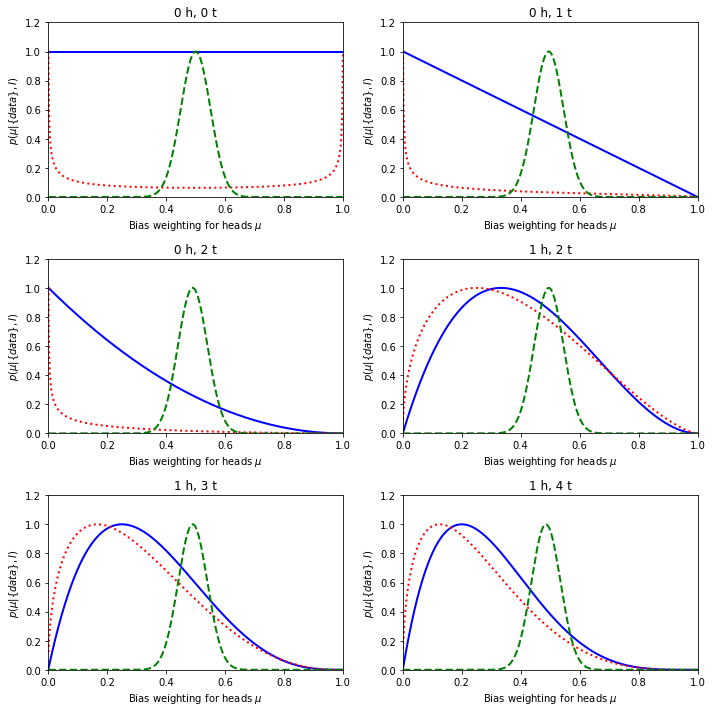

In [15]:
plotbetapdfs(ab[5], [3,2,5], tallies[5])

### 2048 flips

In [16]:
mu = 0.25
tallies = [np.array([0,0])]
ab = [[ np.array([1, 1]), np.array([0.5, 0.5]), np.array([50, 50]) ] ]

for i in np.arange(2048):
    
    tally = np.random.multinomial(1, [mu, 1-mu], size=1)[0]
    tallies.append(tallies[i]+tally)


    
    ab_update = [x+tally for x in ab[i]]
    ab.append(ab_update)

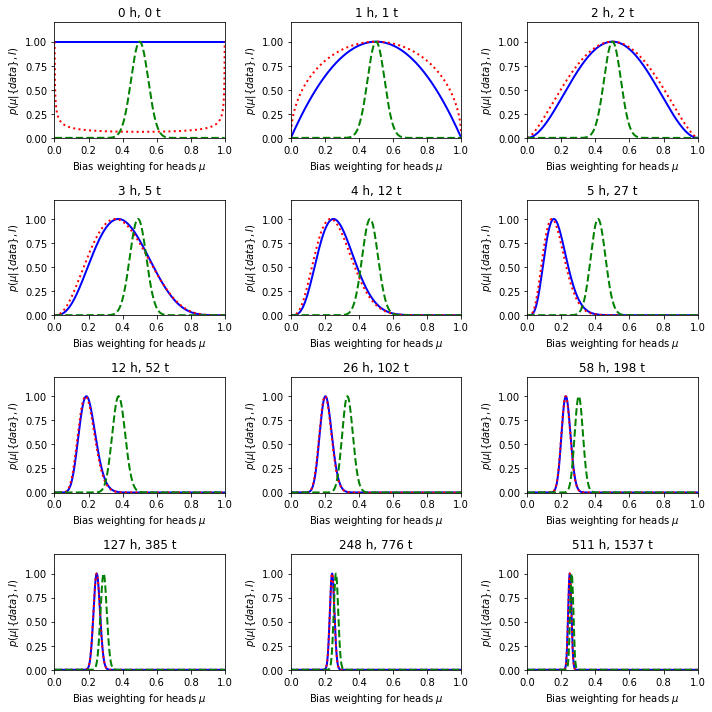

In [29]:
plotbetapdfs(ab[2048], [4,3,11], tallies[2048])

### C

The Beta(a=50, b=50) distribution is more robust to the updating tallies as it continues to be centered around the mean of an unbiased coin.  So here it is clear that the prior is fake data as it does not support the idea that the pribability is in fact 0.25 for heads.

### D

The rather small size of the prior makes it suceptible to the impact of the real observed data. The more flips occured, the more the posterior distributions become similar.
 
 In essence, all the distributions converged close to the same mean because the size of the real data was larger than the size of the prior data.

# Question 4

In [4]:
def plotCurrent(X, Rnk, Kmus):
    N, D = np.shape(X)
    K = np.shape(Kmus)[0]

    InitColorMat = np.matrix([[1, 0, 0], 
                              [0, 1, 0],   
                              [0, 0, 1],
                              [0, 0, 0],
                              [1, 1, 0], 
                              [1, 0, 1], 
                              [0, 1, 1]])

    KColorMat = InitColorMat[0:K]
    colorVec = Rnk.dot(KColorMat)
    muColorVec = np.eye(K).dot(KColorMat)

    plt.scatter(X[:,0], X[:,1], edgecolors=colorVec, marker='o', facecolors='none', alpha=0.3)
    plt.scatter(Kmus[:,0], Kmus[:,1], c=muColorVec, marker='D', s=50);

In [5]:
data = np.loadtxt('faithful.txt')

In [6]:
def calcSqDistances(X, Kmus):
    # sqDmat will be an N-by-K matrix with the n,k entry as specfied above
    squared_center_sums = np.sum(np.multiply(Kmus,Kmus), axis=1).T
    squared_x_sums = np.sum(np.multiply(X,X), axis=1)
    dists = ((-2 * X.dot(Kmus.T) + squared_center_sums).T + squared_x_sums).T
    return dists

In [7]:
#REDONE FOR HW RESUBMISSION

def determineRnk(sqDmat):
    #  R will be an N-by-K matrix of binary values whose n,k entry is set as per Bishop (9.2)
    rnk = np.argmin(sqDmat, axis=1)
    rnk_mat = np.eye(sqDmat.shape[1])[rnk]
    return rnk_mat

In [10]:
def recalcMus(X, Rnk):
    # Recalculate mu values based on cluster assignments as per Bishop (9.4)
    rnk_sum = X.T.dot(Rnk)
    x_to_rnk = np.sum(Rnk, axis=0)
    new_mus = (np.divide(rnk_sum, x_to_rnk)).T
    return new_mus

In [11]:
def runKMeans(K, fileString):
    # Load data file specified by fileStringfrom Bishop book
    X = np.loadtxt(fileString)

    # Determine and store data set information
    N = np.shape(X)[0]
    D = np.shape(X)[1]

    # Allocate space for the K mu vectors
    Kmus = np.zeros((K, D))

    # Initialize cluster centers by randomly picking points from the data
    rndinds = np.random.permutation(N)
    Kmus = X[rndinds[:K]];

    # Specify the maximum number of iterations to allow
    maxiters = 1000;

    for iter in range(maxiters):
        # Assign each data vector to closest mu vector as per Bishop (9.2)
        # Do this by first calculating a squared distance matrix where the n,k entry
        # contains the squared distance from the nth data vector to the kth mu vector

        # sqDmat will be an N-by-K matrix with the n,k entry as specfied above
        sqDmat = calcSqDistances(X, Kmus);

        # given the matrix of squared distances, determine the closest cluster
        # center for each data vector 

        # R is the "responsibility" matrix
        # R will be an N-by-K matrix of binary values whose n,k entry is set as 
        # per Bishop (9.2)
        # Specifically, the n,k entry is 1 if point n is closest to cluster k,
        # and is 0 otherwise
        Rnk = determineRnk(sqDmat)

        KmusOld = Kmus
        plotCurrent(X, Rnk, Kmus)
        plt.show()

        # Recalculate mu values based on cluster assignments as per Bishop (9.4)
        Kmus = recalcMus(X, Rnk)

        # Check to see if the cluster centers have converged.  If so, break.
        if sum(abs(KmusOld.flatten() - Kmus.flatten())) < 1e-6:
            break

    plotCurrent(X,Rnk,Kmus)

## K = 2

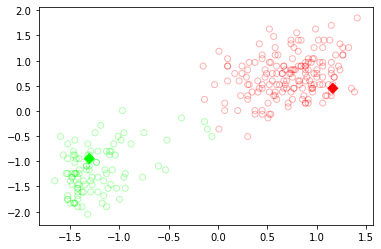

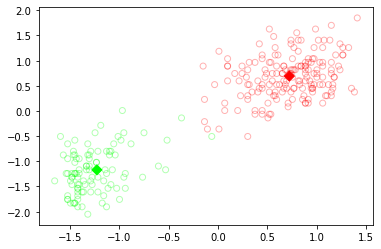

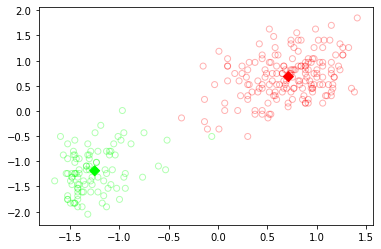

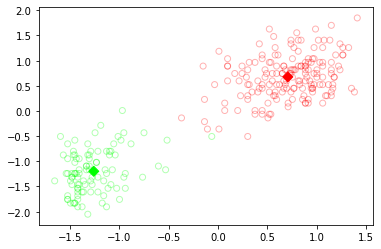

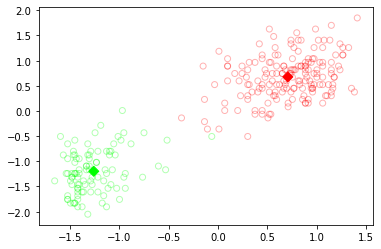

In [14]:
runKMeans(2, 'scaledfaithful.txt')

## K = 3

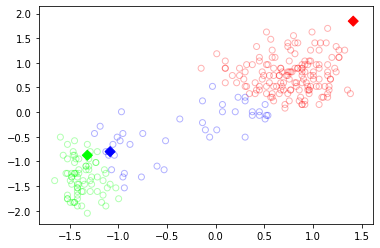

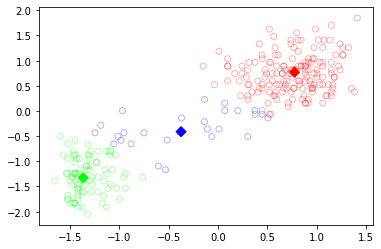

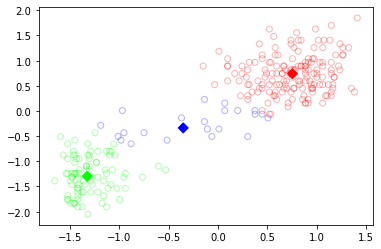

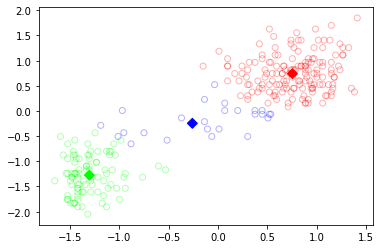

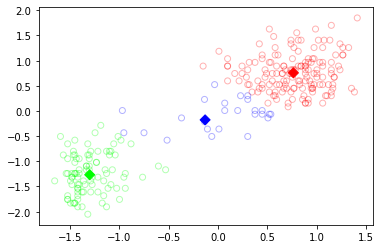

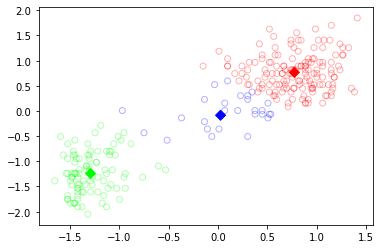

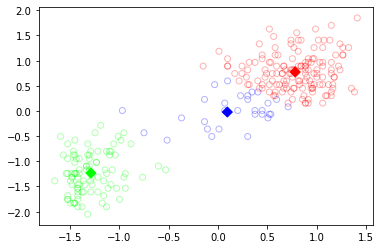

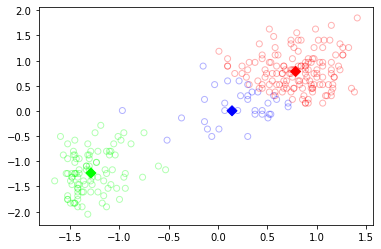

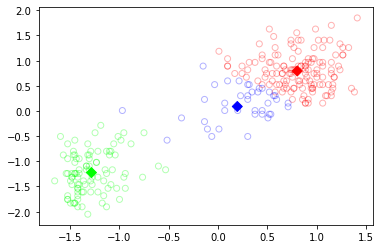

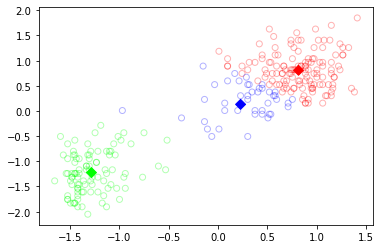

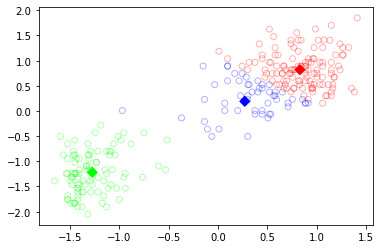

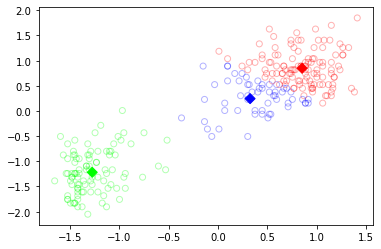

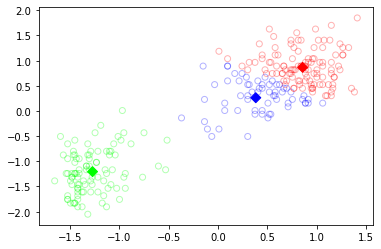

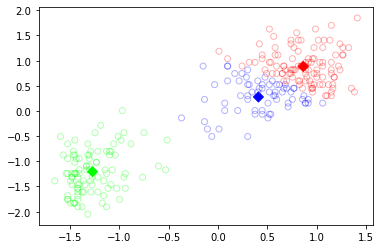

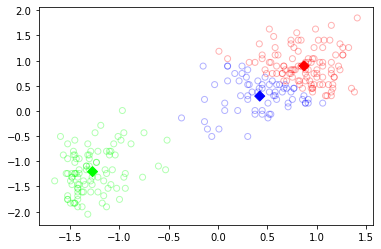

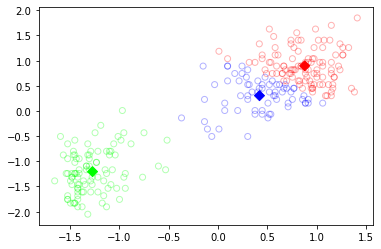

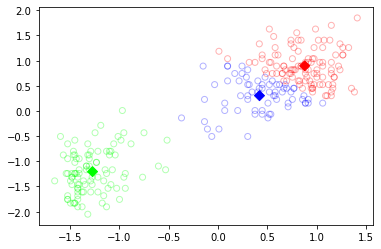

In [12]:
runKMeans(3, 'scaledfaithful.txt')

## K = 4

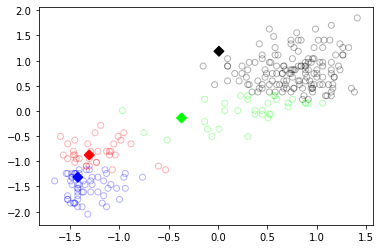

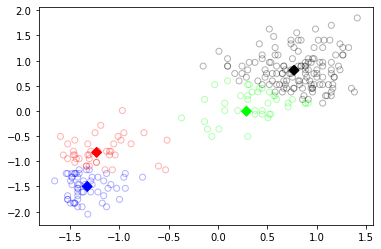

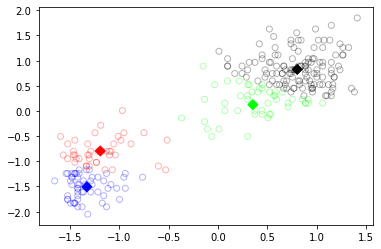

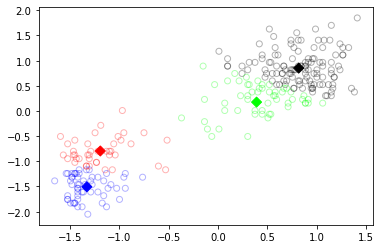

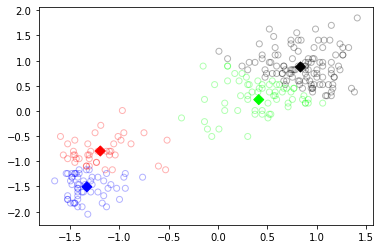

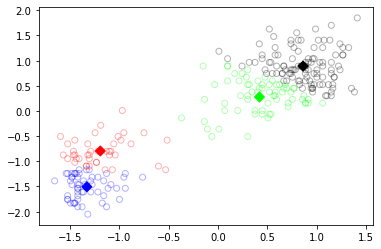

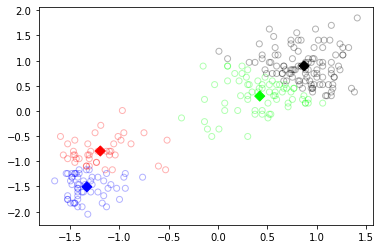

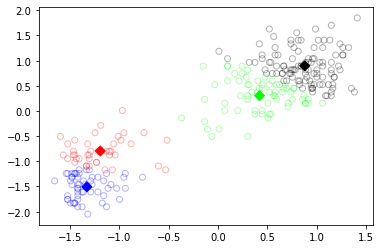

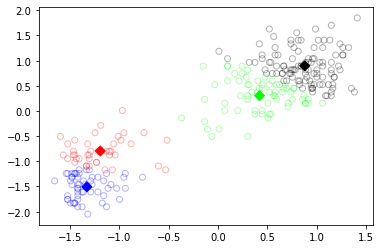

In [13]:
runKMeans(4, 'scaledfaithful.txt')

# Question 5

<img src = '5a.jpeg'>
<img src = '5b.jpeg'>

# Question 6

<img src = '6.jpeg'>